In [14]:
!pip install --upgrade imbalanced-learn==0.10.1

In [15]:
IMG_SIZE = (256, 256)
BATCH_SIZE = 16
EPOCHS = 100
data_dir = "/kaggle/input/ppmim1/MRI-CONV--v1"
classes = ["NONPD", "PD"]

X, y = [], []
for idx, cls in enumerate(classes):
    class_path = os.path.join(data_dir, cls)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.resize(img, IMG_SIZE)
        X.append(img)
        y.append(idx)

X = np.array(X, dtype='float32') / 255.0
y = np.array(y)
print("Data loaded:", X.shape, "Labels:", y.shape) 

Data loaded: (1070, 256, 256, 3) Labels: (1070,)


In [16]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [17]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator() 

train_generator = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
val_generator = val_datagen.flow(X_val, y_val, batch_size=BATCH_SIZE)


In [18]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = True  

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer_4[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 24,112,770 (91.98 MB)

 Trainable params: 24,059,650 (91.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [19]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, verbose=1)


In [20]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    callbacks=[reduce_lr],
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 100s 673ms/step - accuracy: 0.7023 - loss: 0.6595 - val_accuracy: 0.2523 - val_loss: 0.7662 - learning_rate: 1.0000e-04
Epoch 2/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 230ms/step - accuracy: 0.7254 - loss: 0.5701 - val_accuracy: 0.7477 - val_loss: 1.0507 - learning_rate: 1.0000e-04
Epoch 3/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 222ms/step - accuracy: 0.7541 - loss: 0.5006 - val_accuracy: 0.2523 - val_loss: 0.8480 - learning_rate: 1.0000e-04
Epoch 4/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 226ms/step - accuracy: 0.7385 - loss: 0.5083 - val_accuracy: 0.2523 - val_loss: 0.8904 - learning_rate: 1.0000e-04
Epoch 5/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 220ms/step - accuracy: 0.7358 - loss: 0.5051 - val_accuracy: 0.6636 - val_loss: 0.6762 - learning_rate: 1.0000e-04
Epoch 6/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 226ms/step - accuracy: 0.7712 - loss: 0.4486 - val_accuracy: 0.2523 - val_loss: 0.8458 - learning_rate: 1.0000e-04
Epoch 7/100
54/54 ━━━━━━━━━━━━━━━━━━━━ 13s 235ms/st

7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 942ms/step

Evaluation Metrics:
Accuracy  : 0.8645
Precision : 0.8637
Recall    : 0.8645
F1-score  : 0.8641

Classification Report:

              precision    recall  f1-score   support

       NONPD       0.74      0.72      0.73        54
          PD       0.91      0.91      0.91       160

    accuracy                           0.86       214
   macro avg       0.82      0.82      0.82       214
weighted avg       0.86      0.86      0.86       214



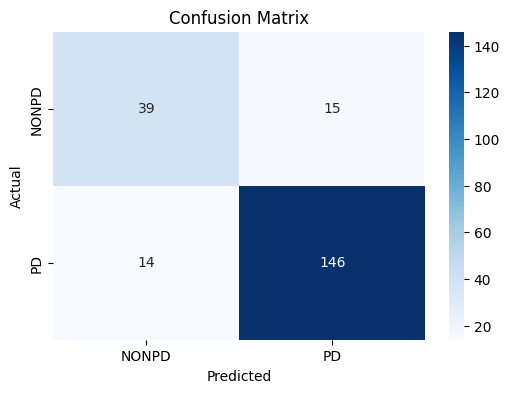

In [21]:
X_val_norm = X_val
y_pred_prob = model.predict(X_val_norm)
y_pred = np.argmax(y_pred_prob, axis=1)

acc = accuracy_score(y_val, y_pred)
prec = precision_score(y_val, y_pred, average='weighted', zero_division=0)
rec = recall_score(y_val, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_val, y_pred, average='weighted', zero_division=0)

print("\nEvaluation Metrics:")
print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1-score  : {f1:.4f}")

print("\nClassification Report:\n")
print(classification_report(y_val, y_pred, target_names=classes, zero_division=0))

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()



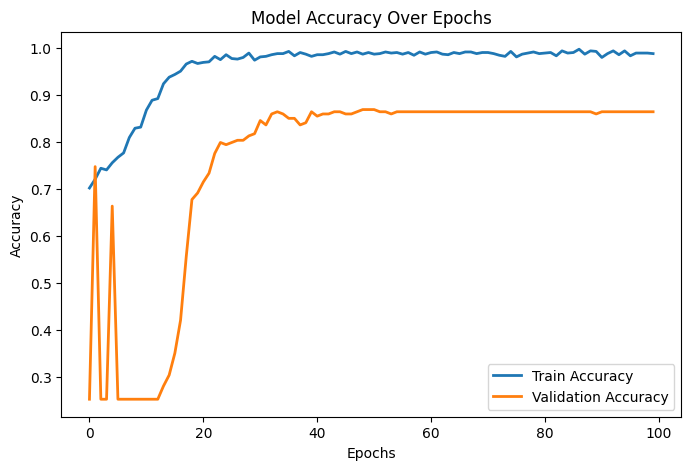

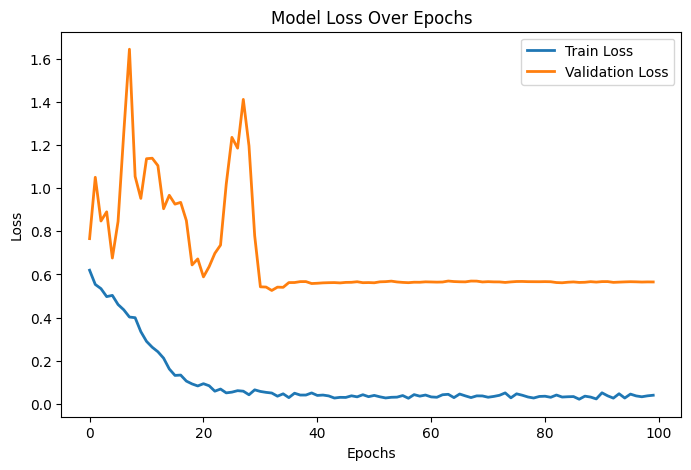

In [22]:
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title("Model Accuracy Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title("Model Loss Over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
